# Classify GTeX eQTLs vs negative variants

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import average_precision_score, precision_recall_curve
import anndata
from plotnine import *
import os
from tqdm import tqdm

In [2]:
def compute_ap_with_bootstrap(y_true: np.ndarray, y_scores: np.ndarray, n_bootstraps: int = 100, 
                              confidence_level: float = 0.95):
    """
    Computes the Average Precision and its bootstrapped confidence interval.

    Args:
        y_true (np.ndarray): True binary labels (0 or 1).
        y_scores (np.ndarray): Target scores, can either be probability estimates of the positive class,
                                confidence values, or non-thresholded decision values.
        n_bootstraps (int): Number of bootstrap samples to draw. Defaults to 1000.
        confidence_level (float): The desired confidence level for the interval (e.g., 0.95 for 95%).
                                  Defaults to 0.95.

    Returns:
        tuple: A tuple containing:
            - auprc (float): The single AP score computed on the full dataset.
            - lower_bound (float): The lower bound of the confidence interval.
            - upper_bound (float): The upper bound of the confidence interval.
            - auprc_scores (list): A list of AP scores from each bootstrap sample.
    """

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Check for valid input dimensions
    if y_true.shape != y_scores.shape:
        print("Error: y_true and y_scores must have the same shape.")
        return None, None, None, None
    if y_true.ndim > 1 or y_scores.ndim > 1:
        print("Error: y_true and y_scores must be 1-dimensional arrays.")
        return None, None, None, None
    if not np.isin(y_true, [0, 1]).all():
        print("Error: y_true must contain only 0s and 1s.")
        return None, None, None, None

    # Compute AUPRC on the original dataset
    auprc = average_precision_score(y_true, y_scores)

    # Store AUPRC scores from bootstrap samples
    auprc_scores = []
    n_samples = len(y_true)

    for i in range(n_bootstraps):
        # Sample with replacement (bootstrapping)
        # We sample indices to keep y_true and y_scores aligned
        indices = np.random.choice(n_samples, n_samples, replace=True)
        boot_y_true = y_true[indices]
        boot_y_scores = y_scores[indices]

        # Handle cases where a bootstrap sample might have only one class
        # (which breaks average_precision_score)
        if len(np.unique(boot_y_true)) < 2:
            continue # Skip this sample if it doesn't have both classes

        try:
            boot_auprc = average_precision_score(boot_y_true, boot_y_scores)
            auprc_scores.append(boot_auprc)
        except Exception as e:
            continue

    # Convert to numpy array for percentile calculation
    auprc_scores = np.array(auprc_scores)

    if len(auprc_scores) == 0:
        print("Error: No valid AUPRC scores could be computed from bootstrap samples.")
        return auprc, np.nan, np.nan, []

    # Calculate confidence interval
    alpha = 1.0 - confidence_level
    lower_percentile = alpha / 2.0 * 100
    upper_percentile = (1.0 - alpha / 2.0) * 100

    lower_bound = np.percentile(auprc_scores, lower_percentile)
    upper_bound = np.percentile(auprc_scores, upper_percentile)

    return np.round(auprc, 3), np.round(lower_bound, 3), np.round(upper_bound, 3)

## Paths

In [3]:
out_dir = '/gstore/data/resbioai/grelu/decima/20240823/bulk_eqtl_results/'
susie_file = os.path.join(out_dir, 'gtex_eqtl_cat_susie_scored.csv')

## Load results

In [4]:
susie = pd.read_csv(susie_file)

## Compute absolute VEP scores

In [5]:
susie.head()

,variant,beta,gene,celltype,abspos_rel_TSS,label,decima_score,borzoi_score,abs_decima_score,abs_borzoi_score
0,chr1_100353172_T_G,-0.261039,CDC14A,adipose_subcutaneous,8170,True,-0.008337,0.003699,0.008337,0.003699
1,chr1_107135646_G_C,1.297660,NTNG1,adipose_subcutaneous,4362,True,0.261189,0.419811,0.261189,0.419811
2,chr1_109509517_A_G,0.710806,AMIGO1,adipose_subcutaneous,221,True,0.068010,0.099049,0.068010,0.099049
3,chr1_109671748_C_T,0.523832,GSTM1,adipose_subcutaneous,16067,True,-0.000409,-0.000540,0.000409,0.000540
4,chr1_109675302_G_A,-0.803308,GSTM1,adipose_subcutaneous,12513,True,0.003071,0.000005,0.003071,0.000005


In [6]:
cts = susie.celltype.unique()
cts_w_borzoi = susie.dropna(subset='borzoi_score').celltype.unique()
len(cts), len(cts_w_borzoi)

(33, 23)

## Compute overall AP

### All tissues

In [7]:
positive_genes = susie[susie.label].gene
negative_genes = susie[~susie.label].gene

sub = susie[susie.gene.isin(set(positive_genes).intersection(negative_genes))]
print(len(sub[sub.label]), len(sub[~sub.label]))

10943 292474


In [8]:
decima_ap = compute_ap_with_bootstrap(sub.label, sub.abs_decima_score)
distance_ap = compute_ap_with_bootstrap(sub.label, -sub.abspos_rel_TSS)
for ap in [decima_ap, distance_ap]:
    print(f"AP: {ap[0]:.2f} Lower: {ap[1]:.2f} Upper: {ap[2]:.2f}")

AP: 0.35 Lower: 0.34 Upper: 0.36
AP: 0.15 Lower: 0.14 Upper: 0.16


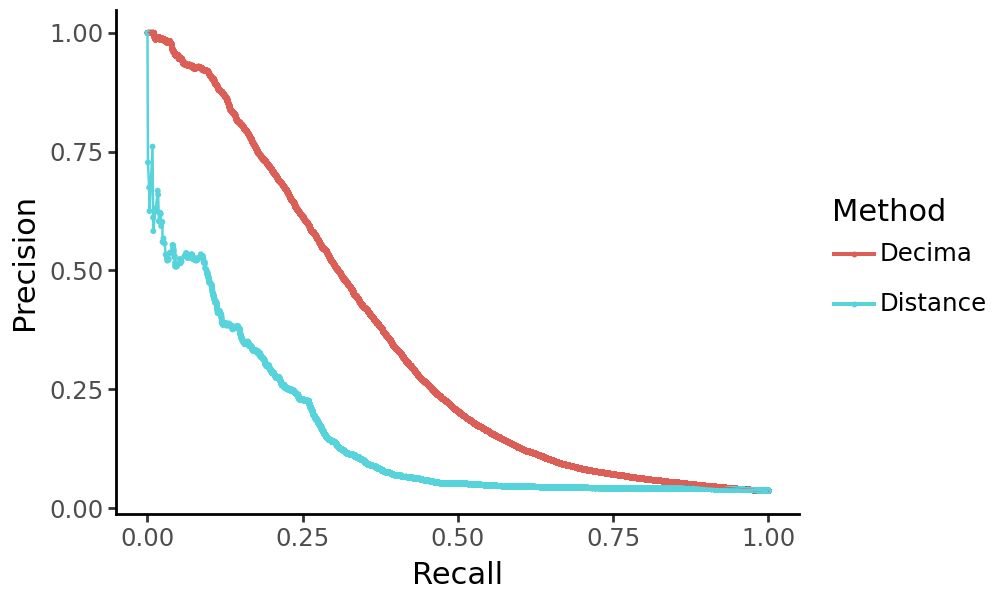

In [9]:
p_decima, r_decima, _ = precision_recall_curve(sub.label, sub.abs_decima_score)
p_dist, r_dist, _ = precision_recall_curve(sub.label, -sub.abspos_rel_TSS)

df = pd.concat([
    pd.DataFrame({'Method':'Decima', 'Recall':r_decima, 'Precision':p_decima}),
     pd.DataFrame({'Method':'Distance', 'Recall':r_dist, 'Precision':p_dist}),
])  
(
    ggplot(df, aes(x='Recall', y='Precision', color='Method')) + geom_point(size=.2)
    + geom_line()
    + theme_classic() + theme(figure_size=(5,3))
)

### Incluing Borzoi

In [10]:
sub_w_borzoi = sub[sub.celltype.isin(cts_w_borzoi)]
print(len(sub_w_borzoi[sub_w_borzoi.label]), len(sub_w_borzoi[~sub_w_borzoi.label]))

decima_ap = compute_ap_with_bootstrap(sub_w_borzoi.label, sub_w_borzoi.abs_decima_score)
borzoi_ap = compute_ap_with_bootstrap(sub_w_borzoi.label, sub_w_borzoi.abs_borzoi_score)
distance_ap = compute_ap_with_bootstrap(sub_w_borzoi.label, -sub_w_borzoi.abspos_rel_TSS)

for ap in [decima_ap, borzoi_ap, distance_ap]:
    print(f"AP: {ap[0]:.2f} Lower: {ap[1]:.2f} Upper: {ap[2]:.2f}")

8434 225690
AP: 0.36 Lower: 0.35 Upper: 0.37
AP: 0.38 Lower: 0.37 Upper: 0.39
AP: 0.16 Lower: 0.15 Upper: 0.17


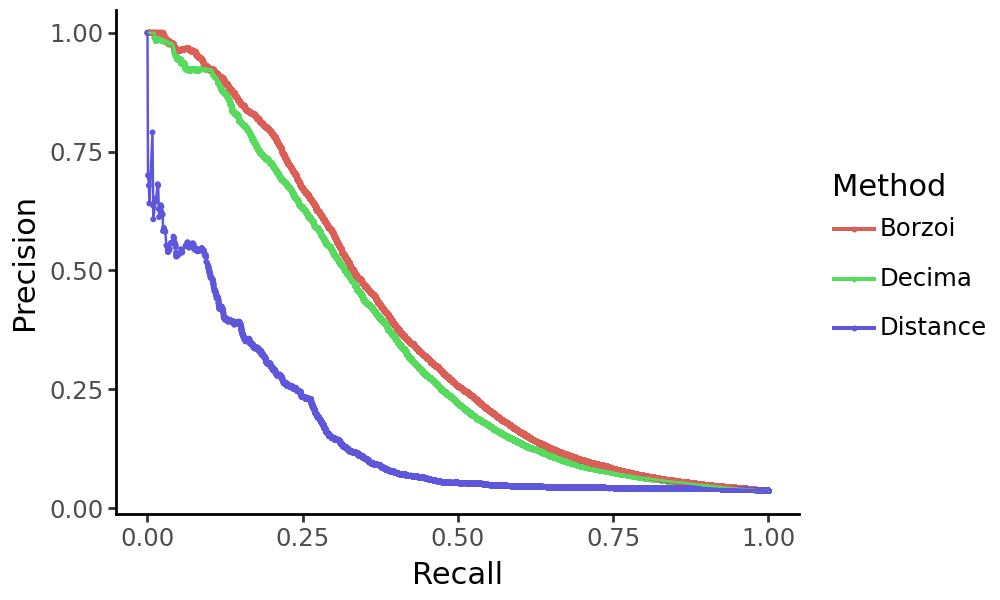

In [11]:
p_decima, r_decima, _ = precision_recall_curve(sub_w_borzoi.label, sub_w_borzoi.abs_decima_score)
p_borzoi, r_borzoi, _ = precision_recall_curve(sub_w_borzoi.label, sub_w_borzoi.abs_borzoi_score)
p_dist, r_dist, _ = precision_recall_curve(sub_w_borzoi.label, -sub_w_borzoi.abspos_rel_TSS)

df = pd.concat([
    pd.DataFrame({'Method':'Decima', 'Recall':r_decima, 'Precision':p_decima}),
    pd.DataFrame({'Method':'Borzoi', 'Recall':r_borzoi, 'Precision':p_borzoi}),
    pd.DataFrame({'Method':'Distance', 'Recall':r_dist, 'Precision':p_dist}),
])  

(
    ggplot(df, aes(x='Recall', y='Precision', color='Method')) + geom_point(size=.2)
    + geom_line()
    + theme_classic() + theme(figure_size=(5,3))
)

## Performance per cell type


In [12]:
res = []
for ct in tqdm(cts):

    # Subset
    susie_ct = susie[susie.celltype==ct]

    # Select genes with positives and negatives
    pos_genes = susie_ct[susie_ct.label].gene.unique()
    neg_genes = susie_ct[~susie_ct.label].gene.unique()
    sel_genes = set(pos_genes).intersection(neg_genes)
    
    # Select matched positives and negatives
    matched_neg = susie_ct[(~susie_ct.label) & (susie_ct.gene.isin(sel_genes))]
    matched_pos = susie_ct[(susie_ct.label) & (susie_ct.gene.isin(sel_genes))]
    positives = len(matched_pos)
    negatives = len(matched_neg)
    sub = pd.concat([matched_pos, matched_neg])

    # Compute AP
    decima_ap = compute_ap_with_bootstrap(sub.label, sub.abs_decima_score, n_bootstraps=100)
    distance_ap = average_precision_score(sub.label, -sub.abspos_rel_TSS)
    if ct in cts_w_borzoi:
        borzoi_ap = compute_ap_with_bootstrap(sub.label, sub.abs_borzoi_score, n_bootstraps=100)
    else:
        borzoi_ap = [np.nan]*3
    
    res.append({
        'tissue':ct,
        'decima_ap':decima_ap[0], 'decima_lower':decima_ap[1], 'decima_upper':decima_ap[2],
        'borzoi_ap':borzoi_ap[0], 'borzoi_lower':borzoi_ap[1], 'borzoi_upper':borzoi_ap[2],
        'distance_ap':distance_ap, 'positives':positives, 'negatives':negatives,
    })

res = pd.DataFrame(res)

100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


In [16]:
len(res[res.decima_ap >= res.borzoi_ap]), len(res[res.decima_ap < res.borzoi_ap])

(5, 18)

## Visualize

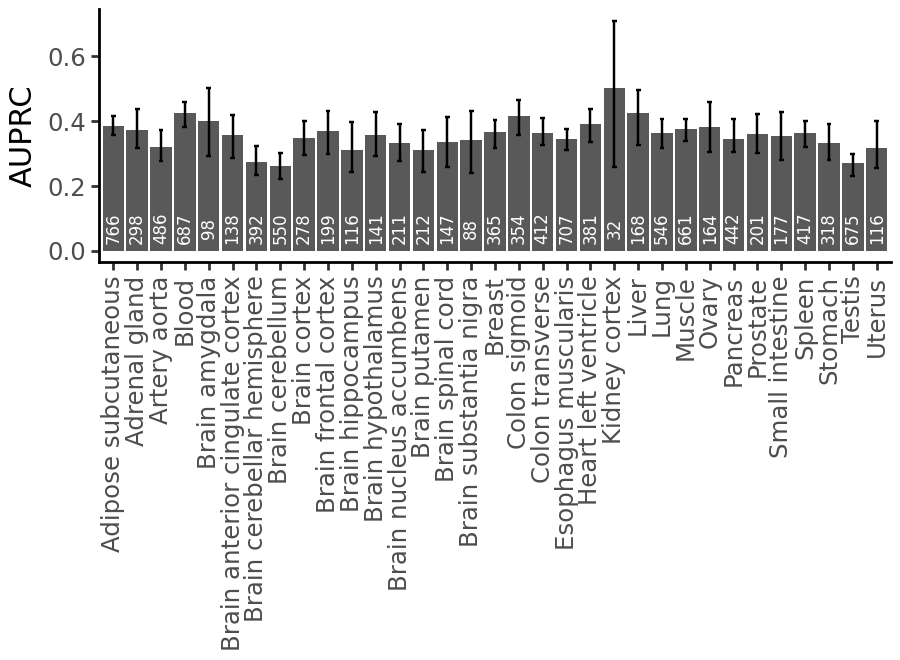

In [15]:
res.tissue = res.tissue.apply( lambda x: x[0].upper() + x[1:].replace('_', ' '))
#res.tissue = pd.Categorical(res.tissue, categories=res.sort_values('decima_ap', ascending=False).tissue.tolist())
(
    ggplot(res, aes(x='tissue', y='decima_ap')) + geom_col() + theme_classic()
    + theme(figure_size=(4.5, 3.3)) 
    + theme(axis_text_x=element_text(rotation=90, hjust=.5))
    + xlab("") + ylab("AUPRC")
    + geom_errorbar(aes(ymin='decima_lower', ymax='decima_upper'), width=0.2)
    + geom_text(aes(label='positives', y=0.07), size=6, color='white', angle=90)
)

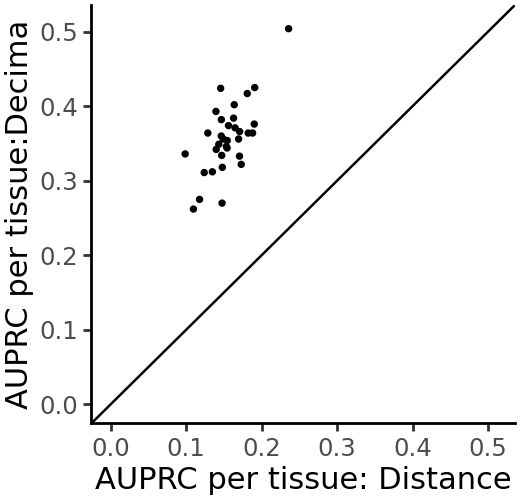

In [62]:
(
    ggplot(res, aes(x='distance_ap', y = 'decima_ap')) +\
    geom_point(size=.5) + theme_classic() + theme(figure_size=(2.6,2.5)) 
    + geom_abline(intercept=0, slope=1) 
    + xlab("AUPRC per tissue: Distance") + ylab("AUPRC per tissue:Decima")
    + ylim(0, 0.51)
    + xlim(0, 0.51)
)

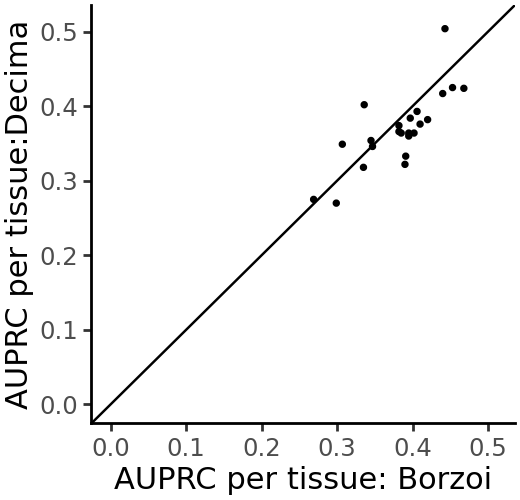

In [63]:
res_w_borzoi = res.dropna(subset='borzoi_ap')
(
    ggplot(res_w_borzoi, aes(x='borzoi_ap', y = 'decima_ap')) +\
    geom_point(size=.5) + theme_classic() + theme(figure_size=(2.6,2.5)) 
    + geom_abline(intercept=0, slope=1) 
    + xlab("AUPRC per tissue: Borzoi") + ylab("AUPRC per tissue:Decima")
    + ylim(0, 0.51)
    + xlim(0, 0.51)
)